# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import lognorm

disable deprecated pandas warning

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

Default variable

In [3]:
DEFAULT_EXPLANATION_PERIOD = 30
DEFAULT_IN_SAMPLE_MONTH = 1
DEFAULT_HALF_LIFE = 3600

DEFAULT_STOCK = "AAPL"
DEFAUL_DATE = "2019-02-14"
SMOOTHING_FACTOR = .02

DEFAULT_SPREAD = 0.0001 # 1 bps

util func

In [4]:
def calculate_performance_metrics(pnl: pd.Series) -> dict:   

    pnl = pnl[pnl != 0].dropna()
    returns = pnl.pct_change().dropna()

    sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

    # calculate maximum drawdown
    cum_returns = returns.cumsum()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = cum_returns - running_max
    max_drawdown = drawdown.min()

    # calculate final wealth
    final_wealth = pnl.iloc[-1]

    # create dictionary of performance metrics
    performance_metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Final Wealth': final_wealth
    }

    return performance_metrics

In [5]:
def pivot_trade_px_df(trade_df : pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "mid", "time"]].pivot(index=["stock", "date"], columns=["time"])["mid"].fillna(method="ffill", axis="columns").fillna(method="bfill", axis="columns")

In [6]:
def pivot_trade_volume_df(trade_df:pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "trade","time"]].pivot(index=["stock", "date"],columns=["time"])["trade"].fillna(0).astype(int)

In [7]:
def pivot_trade_spread_df(trade_df:pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "spread","time"]].pivot(index=["stock", "date"],columns=["time"])["spread"].fillna(0).astype(float)

# Data pipeline

## Base data import

We create function to import the bin and fill data (by sampling many CSV files)

In [8]:
def import_data(path="data_lobster/binSamples",file_limit = None,columns = ["date","time","stock","trade","mid","spread"]):
    columns = columns + ["date"] if "date" not in columns else columns
    data = pd.DataFrame(columns=columns)
    file_limit = len(os.listdir(path=path)) if file_limit is None else min(len(os.listdir(path=path)),file_limit)
    for index,csv_file in enumerate(os.listdir(path=path)[:file_limit]):
        print(f"Reading file : {index+1} out of {file_limit} ...",end="\r")
        df = pd.read_csv(f"{path}/{csv_file}")[columns]
        data = pd.concat([data,df])
    data["date"] = pd.to_datetime(data["date"])
    data = data.drop_duplicates()
    print(f"Done reading file.                      ",end="\r")
    return data

In [9]:
if "bin_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/") : 
    bin_sample_df = import_data(path="data_lobster/binSamples",file_limit = 6)
    bin_sample_df.to_csv("data_lobster/refined_data/bin_sample_all_file.csv",index=False)
else:
    bin_sample_df = pd.read_csv("data_lobster/refined_data/bin_sample_all_file.csv")
    bin_sample_df["date"] = pd.to_datetime(bin_sample_df["date"])

In [10]:
if "fill_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/"): 
    fill_sample_df = import_data(path="data_lobster/fillSamples",file_limit = None)
    fill_sample_df.to_csv("data_lobster/refined_data/fill_sample_all_file.csv",index=False)
else:
    fill_sample_df = pd.read_csv("data_lobster/refined_data/fill_sample_all_file.csv")
    fill_sample_df["date"] = pd.to_datetime(fill_sample_df["date"])

## Volume curves

In [11]:
def get_volume_curve_df(bin_sample_data:pd.DataFrame,date = None)->pd.DataFrame :
    if date is not None:
        #If date is not None => Need to truncate the input dataframe to the last month before the provided date
        #Else, assume it's already been done
        bin_sample_data = bin_sample_data[(date - bin_sample_data["date"]<=datetime.timedelta(days = 31)) & (date - bin_sample_data["date"] >= datetime.timedelta(days=0))]
    traded_volume_df = pivot_trade_volume_df(bin_sample_data)
    unsigned_traded_volume_df = traded_volume_df.abs().reset_index()
    volume_curve_df = unsigned_traded_volume_df.groupby(["stock"]).mean()
    volume_curve_df.iloc[:,:] = volume_curve_df.values[:,::-1].cumsum(axis=1)[:,::-1] 
    return volume_curve_df

Plot the volume curves for two stock/date pair

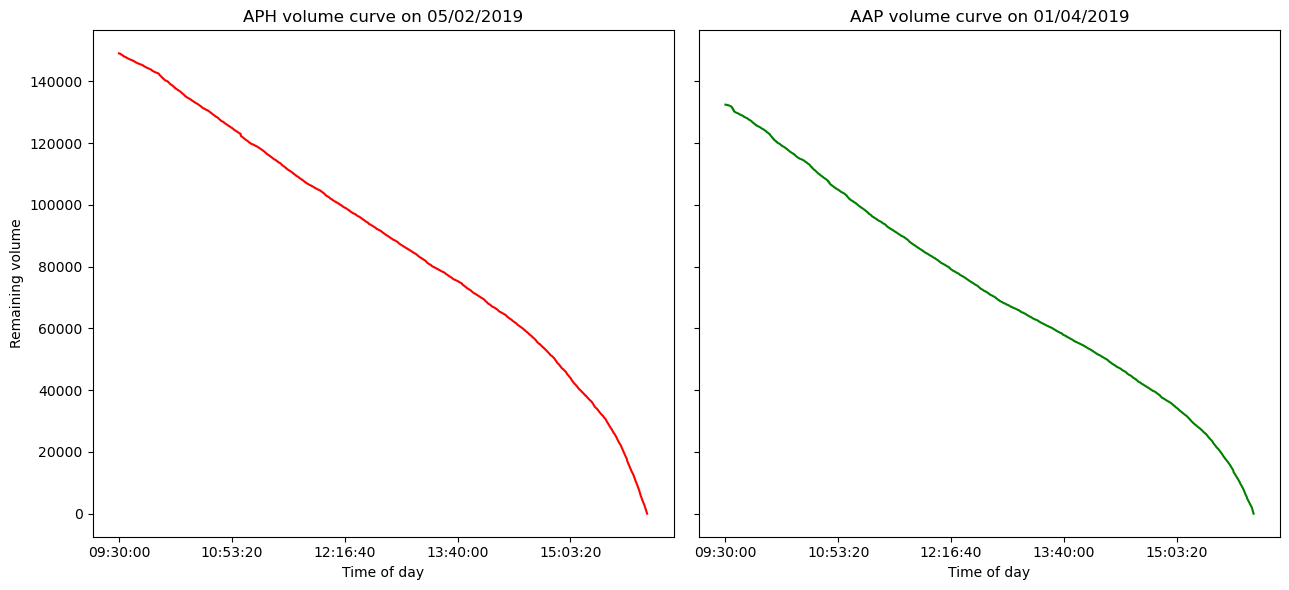

In [12]:
stock_date_pairs = [("APH",datetime.datetime(year = 2019,day = 5, month = 2),"red"),("AAP",datetime.datetime(year = 2019,day = 1, month = 4),"green")]

fig,axs = plt.subplots(1,2,figsize = (13,6),sharey=True)
for index,(stock,date,color) in enumerate(stock_date_pairs):
    ax = axs[index]
    monthly_volume_curve_df = get_volume_curve_df(bin_sample_data=bin_sample_df,date = date)
    monthly_volume_curve_df.loc[stock,:].T.plot(ax = ax,color=color)
    ax.set_title(f"{stock} volume curve on {date.strftime(format='%d/%m/%Y')}")
    if index <len(stock_date_pairs)-1:
        ax.set_ylabel("Remaining volume")
    ax.set_xlabel("Time of day")
plt.tight_layout()
plt.show()

We compute the volume curve for all the stocks for the entire year-worth of data

In [13]:
volume_curve_df = get_volume_curve_df(bin_sample_df,date=None)

# Pratical example : VWAP schedules

In [14]:
def VWAP_naive(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (naive) = abs(vt) / sigma_s(abs(vs)) * Q
    """
    sigma_v = np.abs(v).sum()
    q = np.abs(v)/sigma_v * Q
    return q

def VWAP_slippage(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (slippage) = abs( v(t-dt) ) / sigma_s(abs(vs)) * Q
    """
    rolled_v =  np.roll(v, 1)
    rolled_v[0] = 0
    sigma_v = np.abs(rolled_v).sum()
    q = np.abs(rolled_v)/sigma_v * Q
    return q


def VWAP_realistic(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    V : average traded volume at each time interval t
    Q : target volume trade
    """
    n = len(v)
    q_realistic = np.zeros_like(v)

    abs_v_rolled = np.abs(np.roll(v, 1))
    abs_v_rolled[0] = 0

    q_realistic[0] = np.minimum(abs_v_rolled[0] / V[0] * Q, Q)
    V[V == 0.] = 1e-9
    for t in range(1, n):
        q_cumulative = q_realistic[:t].sum()
        q_remaining = np.maximum(Q - q_cumulative, 0)
        q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)

    return q_realistic


def TWAP(v : np.ndarray, Q : float , V : np.ndarray = None) ->np.ndarray:
    """
    TWAP executes a an equal % of Q at each time step to completion (100 time steps => 0.1*Q order sent at each time step)
    """
    n = len(v)
    q = np.ones_like(v) * Q / n
    return q

Plot the 3 VWAP trading strategies for different execution size to highlight the differences 

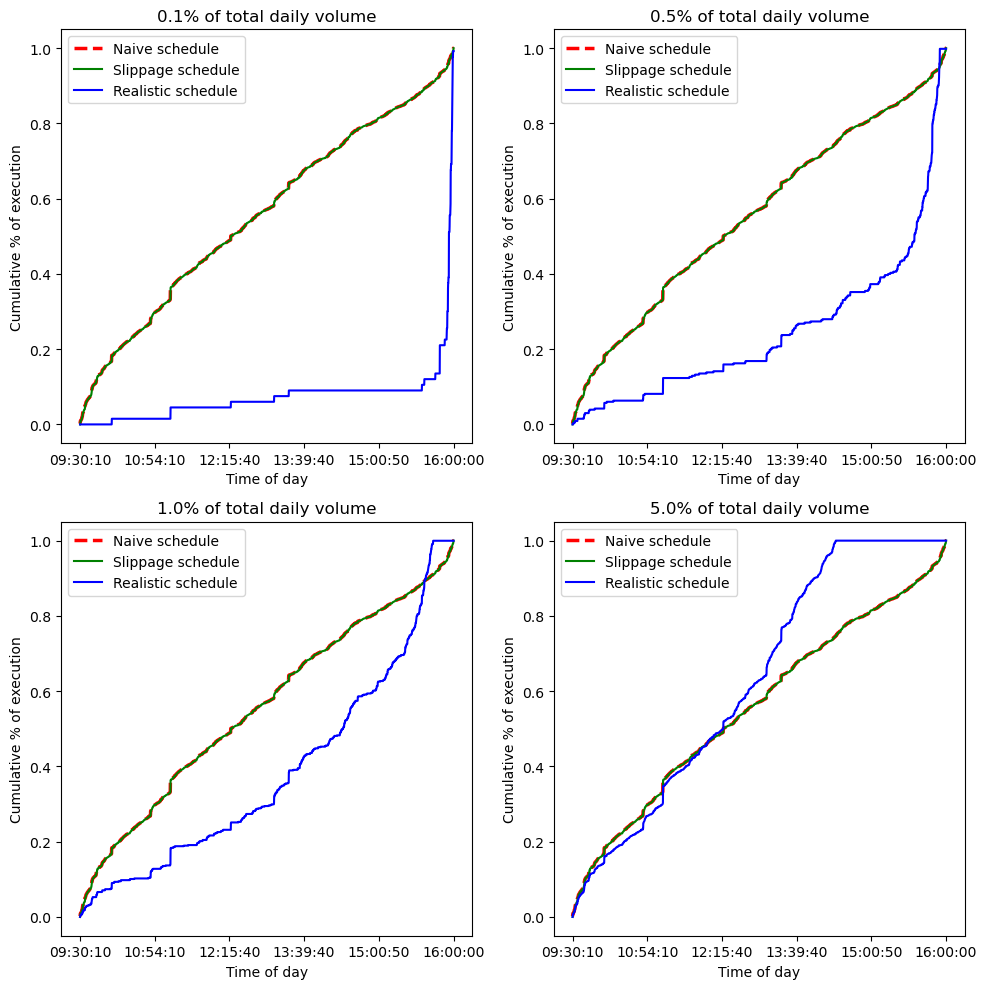

In [15]:
date = datetime.datetime(day = 5,month = 2,year = 2019)
stock = "AAPL"

v = pivot_trade_volume_df(bin_sample_df)
V = get_volume_curve_df(bin_sample_data=bin_sample_df,date=date)


v = v.loc[stock].loc[date].values
V = V.loc[stock].values
Q_pcts = [0.001,0.005,0.01,0.05]

fig,axs = plt.subplots(2,2,figsize = (10,10))
x_values = bin_sample_df["time"].unique()
for index,Q_pct in enumerate(Q_pcts):
    q1 = VWAP_naive(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q2 = VWAP_slippage(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q3 = VWAP_realistic(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())

    ax = axs[index//2][index%2]

    ax.plot(x_values,q1,color="red",label="Naive schedule" ,linestyle = "dashed",linewidth=2.5)
    ax.plot(x_values,q2,color="green",label="Slippage schedule")
    ax.plot(x_values,q3,color="blue",label="Realistic schedule")

    step = len(ax.get_xticks()) // 5
    ax.set_xticks(ax.get_xticks()[::step])

    ax.set_title(f"{Q_pct * 100:.1f}% of total daily volume")
    ax.legend()

    ax.set_xlabel("Time of day")
    ax.set_ylabel("Cumulative % of execution")
plt.tight_layout()
# fig.suptitle(f"Different VWAP schedule for different percentage of total volume of {stock} on {date.strftime('%d/%m/%Y')}", fontsize=16)
plt.show()

# Price impact models

### Computing average daily volume and volatility

In [16]:
def compute_average_daily_volume_and_vol(bin_sample_data:pd.DataFrame) -> pd.DataFrame :
    """
    From the binned data create a data frame indexed stock>date with columns "volume","px_vol" for average daily volume and price volatilty
    """
    adv_ret = bin_sample_data[["stock", "date", "mid","time"]].pivot(index=["stock", "date"],columns=["time"])["mid"]
    adv_ret = adv_ret.fillna(method="bfill",axis=1).fillna(method="ffill",axis=1)
    adv_ret.iloc[:,:] = (adv_ret.iloc[:,:]-np.roll(adv_ret.iloc[:,:],1,axis=1)) / adv_ret.iloc[:,:]
    adv_ret.iloc[:,0] = 0.
    adv_ret["px_vol"] = adv_ret.std(axis=1)
    adv_ret = adv_ret["px_vol"]
    adv_vol = bin_sample_df[["stock", "date","trade"]]
    adv_vol = adv_vol.assign(trade= adv_vol["trade"].abs() )
    adv_vol = adv_vol.groupby(["stock","date"]).agg({"trade":"sum"}).rename(columns= {"trade":"volume"})
    adv_vol = adv_vol.assign(px_vol=adv_ret)
    return adv_vol

def compute_average_rolling_volume_and_vol(adv:pd.DataFrame,window_days = 20) ->pd.DataFrame:
    adv_vol_rolling_mean = adv.rolling(window=window_days).mean().shift(1).dropna()
    return adv_vol_rolling_mean

In [17]:
adv_vol = compute_average_daily_volume_and_vol(bin_sample_df)
adv_vol_rolling_mean = compute_average_rolling_volume_and_vol(adv_vol)

In [18]:
bin_traded_volume = pivot_trade_volume_df(bin_sample_df)
bin_traded_px = pivot_trade_px_df(bin_sample_df)
bin_traded_spread = pivot_trade_spread_df(bin_sample_df)

## PriceImpactModel Class

In [19]:
class PriceImpactModel:
    """
    Main hub to compute the price impact from different model
    Functionnalities : 
        - Fit a price impact model and compute the relevant model coefficients
        - Compute the impact adjusted price from a price impact model
        - Backtest a trading strategy for a stock/date pair
        - Generate Synthetic alpha signals with a constrained correlation to forward returns
        - Create an optimal trading strategy from an alpha signal and a price impact model 
        - Get standard dataframe attribute through a secure interface (get/set)
        - Set in memory previously computed dataframe to optimize computation time
    """

    def __init__(self,bin_sample_data:pd.DataFrame,average_daily_volume_vol:pd.DataFrame = None,bin_traded_volume:pd.DataFrame = None,bin_traded_px :pd.DataFrame = None,bin_traded_spread : pd.DataFrame = None):

        self.__bin_sample_data = bin_sample_data

        #Set attribtue from user input of re-computes them
        self.__average_daily_volume_vol = average_daily_volume_vol if average_daily_volume_vol is not None else compute_average_daily_volume_and_vol(bin_sample_data)
        self.__average_rolling_volume_vol = compute_average_rolling_volume_and_vol(self.__average_daily_volume_vol)
        self.__bin_traded_volume = bin_traded_volume if bin_traded_volume is not None else pivot_trade_volume_df(bin_sample_data)
        self.__bin_traded_px = bin_traded_px if bin_traded_px is not None else pivot_trade_px_df(bin_sample_data)
        self.__bin_traded_spread = bin_traded_spread if bin_traded_spread is not None else pivot_trade_spread_df(bin_sample_data)

        #Database of previously computed computationnal-heavy dataframe
        self.__cum_impact_data = dict()
        self.__regression_result_data = dict()
        self.__no_impact_prices_data = dict()

        self.time_unit = 10 #One data point every 10 seconds

        #Floating point conversion of dataframe (can raise error if not)
        self.__average_daily_volume_vol = self.__average_daily_volume_vol.astype(np.float64)
        self.__average_rolling_volume_vol = self.__average_rolling_volume_vol.astype(np.float64)
        self.__bin_traded_volume = self.__bin_traded_volume.astype(np.float64)
        self.__bin_traded_px = self.__bin_traded_px.astype(np.float64)

        #create a dummy attribute for price impact coef lambdas (filled with 1s)
        self.__impact_coef_one_df = pd.DataFrame(index = self.__average_daily_volume_vol.index ,columns= ["impact_coef"],dtype=np.float32) #all ones dataframe index is multilevel "stock > date"
        self.__impact_coef_one_df.iloc[:] = 1.
    
    def get_bin_traded_px(self):
        return self.__bin_traded_px  
    
    def get_volume_curve_from_data(self,date = None):
        return get_volume_curve_df(bin_sample_data=self.__bin_sample_data,date = date)

    def get_bin_traded_volume(self):
        return self.__bin_traded_volume

    def get_bin_traded_spread(self):
        return self.__bin_traded_spread
    
    def compute_and_store_impact(self,model_type : str,half_life : float , impact_coef_lambda : pd.DataFrame = None,trades : pd.DataFrame = None) -> pd.DataFrame:
        """
        Compute the impact pivoted dataframe with a model type and its relevant half life
        Can supply a lambda coef dataframe, use default one for regression purposes
        """
        if model_type in ["linear","sqrt"]:
            # space kernels
            space_kernels = {
                "linear" : lambda x : x,
                "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
            }
            trades = trades if trades is not None else self.__bin_traded_volume
            impact_coef_lambda = impact_coef_lambda if impact_coef_lambda is not None else self.__impact_coef_one_df
            beta = np.log(2) / half_life # we know that half-life = ln(2)/Beta
            decay_factor = np.exp(-beta * self.time_unit )
            pre_ewm = trades.copy()
            pre_ewm = pre_ewm.divide(self.__average_daily_volume_vol["volume"], axis="rows") 
            alpha = 1-decay_factor
            pre_ewm = space_kernels[model_type](pre_ewm)
                        
            pre_ewm = pre_ewm.multiply(self.__average_daily_volume_vol["px_vol"], axis="rows")
            pre_ewm = pre_ewm.multiply(impact_coef_lambda["impact_coef"],axis = "rows")
            pre_ewm.iloc[:, 1:] /= alpha
            cum_impact = pre_ewm.ewm(alpha=alpha, adjust=False, axis="columns").mean()
            cum_impact = cum_impact.dropna()
            self.__cum_impact_data[(model_type,half_life)] = cum_impact
            return cum_impact
        else:
            raise Exception("Argument Error : model type must be one of 'linear','sqrt'")
        
    def get_cum_impact_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__cum_impact_data.get(key)

    def get_regression_result_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__regression_result_data.get(key)
    
    def get_no_impact_price_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__no_impact_prices_data.get(key)
    
    def get_impact_coef_stock(self,stock):
        res = []
        for key,val in self.__regression_result_data.items():
            res.append((key,val.loc[stock,"beta_estimate"]))
        return res
    
    @staticmethod
    def impact_regression_statistics(cum_impact:pd.DataFrame, explanation_horizon_periods:int, px_df:pd.DataFrame)->pd.DataFrame:
        """
        Compute the regression statistics (x,y,xx,yy,xy) to later compute the unbiaised estimator of the linear regression
        Use a explanation_period h to compute the Impact and Price returns (D_P_h = P_t+h - P_t / Pt and I_t_h = I_t+h - I_t / I_t)
        """
        impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack() #I_t+h - I_t
        reg_stat_df = impact_changes.reset_index().rename({"level_2":"time", 0:"x"}, axis="columns")
        returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack().reset_index().rename({"level_2":"time", 0:"y"}, axis="columns")
        reg_stat_df["y"] = returns["y"]
        reg_stat_df["xy"] = reg_stat_df["x"] * reg_stat_df["y"]
        reg_stat_df["xx"] = reg_stat_df["x"] * reg_stat_df["x"]
        reg_stat_df["yy"] = reg_stat_df["y"] * reg_stat_df["y"]
        reg_stat_df["count"] = 1
        reg_stat_df = reg_stat_df.dropna()
        return reg_stat_df        
    
    def regression_by_model(self,half_life : float,model_type : str,explanation_period : int,in_sample_month : int, out_of_sample_month : int = None) -> pd.DataFrame:
        """
        Compute the coefficient of the linear regression of D_I_h over D_P_h
        Compute the in_sample and out_of_sample characteristics of the linear regression (in sample and out of sample are one month and the one directly after)
        """

        out_of_sample_month = out_of_sample_month if out_of_sample_month is not None else in_sample_month +1

        cum_impact = self.get_cum_impact_by_key((model_type,half_life)) if self.get_cum_impact_by_key((model_type,half_life)) is not None else self.compute_and_store_impact(model_type=model_type,half_life=half_life)
        regression_stats = self.impact_regression_statistics(cum_impact=cum_impact,explanation_horizon_periods=explanation_period,px_df=self.__bin_traded_px)
        
        
        in_sample_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month]
        out_sample_df = regression_stats.loc[regression_stats["date"].dt.month == out_of_sample_month]

        in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
        out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

        summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")

        summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_xx"] * summary_df["is_yy"] / summary_df["is_count"]) / (summary_df["is_xx"] - summary_df["is_x"] ** 2 / summary_df["is_count"])
        summary_df["alpha_estimate"] = summary_df["is_y"] / summary_df["is_count"] - summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"]
        summary_df["is_sse"] = summary_df["is_yy"] - summary_df["is_y"] ** 2 / summary_df["is_count"]
        summary_df["is_mse"] = summary_df["is_yy"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["is_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["is_x"] + summary_df["beta_estimate"] ** 2 * summary_df["is_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["is_count"]
        summary_df["is_rsq"] = 1 - summary_df["is_mse"] / summary_df["is_sse"]
        summary_df["oos_sse"] = summary_df["oos_yy"] - summary_df["oos_y"] ** 2 / summary_df["oos_count"]
        summary_df["oos_mse"] = summary_df["oos_yy"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["oos_x"] + summary_df["beta_estimate"] ** 2 * summary_df["oos_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["oos_count"]
        summary_df["oos_rsq"] = 1 - summary_df["oos_mse"] / summary_df["oos_sse"]

        self.__regression_result_data[(model_type,half_life,explanation_period,in_sample_month)] = summary_df
        
        return summary_df

    def universal_beta(self,model_type,half_life,explanation_period,in_sample_month):

        cum_impact = self.get_cum_impact_by_key((model_type,half_life)) if self.get_cum_impact_by_key((model_type,half_life)) is not None else self.compute_and_store_impact(model_type=model_type,half_life=half_life)
        regression_stats = self.impact_regression_statistics(cum_impact=cum_impact,explanation_horizon_periods=explanation_period,px_df=self.__bin_traded_px)
        
        universal_train_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month]
        universal_beta = (universal_train_df["x"].sum()*universal_train_df["y"].sum() - universal_train_df.shape[0]*(universal_train_df["x"]*universal_train_df["y"]).sum()) / (universal_train_df["x"].sum()**2 - universal_train_df.shape[0]*(universal_train_df["x"]**2).sum())
        
        return universal_beta
    
    def impact_resultant_prices(self,trades :pd.DataFrame, prices :pd.DataFrame, half_life : float, model_type : str)->pd.DataFrame:
        """
        Provided a list of trades, corresponding prices, prices vol and ADC,  and model params (model type, impact coef, half life)
        Returns the price impacted by the trades (computed based on the model params)
        """
        space_kernels_dict = {
            "linear" : lambda x : x,
            "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
        }

        previously_computed_reg_result = [k for k in self.__regression_result_data.keys() if k[0]==model_type and k[1]==half_life]
        if len(previously_computed_reg_result)==0:
            reg_result = self.regression_by_model(half_life=half_life,model_type=model_type,explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=DEFAULT_IN_SAMPLE_MONTH)
        else:
            reg_result = self.__regression_result_data[previously_computed_reg_result[0]]
        impact_coef = reg_result["beta_estimate"] 
        impact_coef = impact_coef.reindex(self.__bin_traded_volume.index,level=0)

        # impact_coef = self.__impact_coef_one_df.copy()["impact_coef"]

        price_vol=self.__average_daily_volume_vol["px_vol"]
        ADV = self.__average_daily_volume_vol["volume"]

        kernel = space_kernels_dict.get(model_type)
        decay_factor = np.exp(-self.time_unit * np.log(2)/half_life)

        trades_copy = trades.copy()
        trades_copy = kernel(trades_copy)
        trades_copy.iloc[:,1:] /= (1 - decay_factor)

        cum_impacts = trades_copy.ewm(alpha=1-decay_factor, adjust=False,axis=1).mean()
        cum_impacts = cum_impacts.multiply(price_vol,axis=0).divide(kernel(ADV),axis=0)
        cum_returns = prices.divide(prices.iloc[:,0],axis=0) -1 
        cum_returns = cum_returns + cum_impacts.multiply(impact_coef,axis=0)
        res = (cum_returns+1).multiply(prices.iloc[:,0],axis = 0)
        return res
    
    def get_no_impact_prices_df(self,half_life:float,model_type : str):
        """
        Wrapper for impact_resultant_prices to remove historical impact, from model parameters (model type and half-life)
        Removes the impact from the whole prices dataframe self.__bin_traded_px (on a copy)
        """

        if self.__no_impact_prices_data.get((model_type,half_life)) is not None:
            return self.__no_impact_prices_data.get((model_type,half_life))
        
        no_impact_prices= self.impact_resultant_prices(trades = -self.__bin_traded_volume,prices =  self.__bin_traded_px,half_life=half_life , model_type = model_type)
        
        self.__no_impact_prices_data[(model_type,half_life)] = no_impact_prices

        return no_impact_prices
    
    def backtest_strategies(self,stock : str,date : str,trades : np.ndarray,half_life : float,model_type : str):
        """
        For a given stock/date pair compute the new simulated price of a serie of trade (="new strategy") :
            - Compute the price without the observed impact with given impact parameters (get_impact_ajusted_prices_df)
            - Compute the impact of the trades on the "no-impact" prices given abobe
            - Sum the impact of the strategy to get its perfomance
        """
        #Get the no impact price for these parameters
        if self.__no_impact_prices_data.get((model_type,half_life)) is not None:
            no_impact_price = self.__no_impact_prices_data.get((model_type,half_life))
        else:
            no_impact_price = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)

        no_impact_price_stock_date_pair = no_impact_price.loc[stock].loc[date].values
        decay = np.exp(-np.log(2) / half_life * self.time_unit )
        space_kernels_dict = {
            "linear" : lambda x : x,
            "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
        }
        kernel = space_kernels_dict.get(model_type)
        
        price_vol=self.__average_rolling_volume_vol.loc[stock].loc[date,"px_vol"]
        ADV = self.__average_rolling_volume_vol.loc[stock].loc[date,"volume"]

        impact_coef_df = self.get_regression_result_by_key((model_type,half_life,DEFAULT_EXPLANATION_PERIOD,DEFAULT_IN_SAMPLE_MONTH))
        impact_coef = impact_coef_df.loc[stock,"beta_estimate"]

        impacted_price = self.impact_resultant_prices_numpy_format(trades = trades,prices=no_impact_price_stock_date_pair,decay=decay,kernel=kernel,price_vol=price_vol,ADV=ADV,impact_coef=impact_coef)
        return impacted_price

    @staticmethod
    def impact_resultant_prices_numpy_format(trades, prices, decay, impact_coef, kernel,price_vol, ADV):
        trades_copy = trades.copy()
        trades_copy = kernel(trades_copy)
        trades_copy[1:] /= (1 - decay)
        trades_copy = pd.Series(trades_copy)
        cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean().values
        cum_impacts *= price_vol / kernel(ADV)
        cum_returns = prices / prices[0] - 1
        cum_returns += cum_impacts * impact_coef
        return prices[0] * (cum_returns + 1)
    
    @staticmethod
    def get_forward_return(prices : pd.DataFrame,h : int):
        h = max(int(h),1)
        r_t_h = (prices.shift(-h,axis = "columns") - prices ).divide(prices)
        return r_t_h

    def synthetic_alpha(self,h : int,rho : float , prices : pd.DataFrame = None):
        """
        Inputs : 
            h (int) : forward look-up period for forward return (1-30 usually)
            rho (float) : constrained correlation of alpha w.r.t forward returns
            prices (pd.Dataframe) : Price dataframe to compute the forward returns on, if not supplied use default __bin_traded_px
        """
        prices = self.__bin_traded_px.copy() if prices is None else prices.copy()
        prices_minus_2 = prices.apply(lambda x : 1/x/x)
        r_t_h = self.get_forward_return(prices=prices,h=h)

        y = rho * np.sqrt(1-rho * rho ) * r_t_h.std(axis="columns") / np.sqrt(h * prices_minus_2.mean(axis="columns"))
        y = np.column_stack([y.to_numpy()] * len(prices.columns))
        x = rho * rho

        brownian_part = y * np.random.normal(loc = 0,scale = np.sqrt(h),size = prices.shape) / prices.values
        
        alpha_t_h = x * r_t_h + brownian_part

        return alpha_t_h
    
    def optimal_impact_state(self,delta_T : int,half_life : float,model_type : str,h : int,rho : float,smoothing_factor :float = None,transaction_cost_enable : bool = False):
        """
        From model type and parameters compute the optimal impact state and trades, using the dynamic liquidity model
        Can include transaction cost (by paying alpha the spread at each trade to cross the order-book)
        returns : 
            alpha_signal (pd.DataFrame) : alpha signal generated with h,rho to compute the optimal impact state
            target_impact (pd.DataFrame) : Optimal impact generated with the synthetic alpha signal
            target_volume (pd.DataFrame) : Optimal trading strategy from the optimal impact (generated using the liquidity model)
            expected_pnl (pd.DataFrame) : Expected P&L of the trading strategy (inclusive of fees if applicable)
            realised_pnl (pd.DataFrame) : Realised P&L of the trading strategy (inclusive of fees if applicable)
        """
        beta = np.log(2) / half_life

        q_t = self.__bin_traded_volume.copy()
        vt = q_t.abs().rolling(window = delta_T,axis="columns").sum().fillna(0)
        
        previously_computed_reg_result = [k for k in self.__regression_result_data.keys() if k[0]==model_type and k[1]==half_life]
        if len(previously_computed_reg_result)==0:
            reg_result = self.regression_by_model(half_life=half_life,model_type=model_type,explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=DEFAULT_IN_SAMPLE_MONTH)
        else:
            reg_result = self.__regression_result_data[previously_computed_reg_result[0]]
        impact_coef = reg_result["beta_estimate"]
        impact_coef = impact_coef.reindex(q_t.index,level=0).multiply(self.__average_daily_volume_vol["px_vol"],axis="rows").divide(np.sqrt(self.__average_daily_volume_vol["px_vol"]),axis="rows")
        
        lambda_t = np.column_stack([impact_coef]*vt.shape[1]) / np.sqrt(vt)
        adjusted_prices = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)

        alpha_signal = self.impact_adjusted_price_with_synth_alpha(half_life=half_life,model_type=model_type,h = h, rho = rho,smoothing_factor = smoothing_factor)
        alpha_signal = alpha_signal.diff(-delta_T,axis="columns")

        alpha_decay_mu_signal = alpha_signal.diff(1,axis="columns").shift(-1,axis="columns").fillna(0.) / self.time_unit


        target_impact = 1/2  *(alpha_signal - alpha_decay_mu_signal / beta)
        impact_over_lambda  = target_impact.divide(lambda_t,axis="rows")
        target_volume = impact_over_lambda + beta * impact_over_lambda.cumsum(axis="columns") * self.time_unit

        transaction_cost_df = self.__bin_traded_spread / 2. if transaction_cost_enable else self.__bin_traded_spread.copy() * 0.

        expected_PNL = (alpha_signal - target_impact - transaction_cost_df).multiply(target_volume,axis="rows").cumsum(axis="columns")
        realised_PNL =  adjusted_prices.multiply(target_volume.cumsum(axis="columns")) -(adjusted_prices +target_impact + transaction_cost_df).multiply(target_volume).cumsum(axis="columns")

        return alpha_signal,target_impact,target_volume,expected_PNL,realised_PNL

    def impact_adjusted_alpha(self, half_life : float, model_type : str, h : int, rho : float,smoothing_factor : float = None):
        """
        From a price impact model and parameter, compute the impact-adjusted price
        Returns an alpha signal fitted to impact-adjusted price generated with a foward look-up period and constrained correlation
        """
        adjusted_price  = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)
        adjusted_synth_alpha = self.synthetic_alpha(h = h,rho = rho,prices = adjusted_price).fillna(0) #last h value for stock date pair is N/A need to fill to 0 (no signal EoD)
        if smoothing_factor:
            adjusted_synth_alpha = adjusted_synth_alpha.ewm(alpha=smoothing_factor,axis="columns").mean()
        return adjusted_synth_alpha

    def impact_adjusted_price_with_synth_alpha(self, half_life : float, model_type : str, h : int, rho : float,smoothing_factor : float = None):
        """
        From a price impact model and parameter, compute the impact-adjusted price
        Returns the alpha-impacted price generated with a foward look-up period and constrained correlation
        """
        adjusted_price  = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)
        adjusted_synth_alpha = self.synthetic_alpha(h = h,rho = rho,prices = adjusted_price).fillna(0)

        cum_returns = adjusted_price.divide(adjusted_price.iloc[:,0],axis=0) -1 
        cum_returns = cum_returns + adjusted_synth_alpha
        res = (cum_returns+1).multiply(adjusted_price.iloc[:,0],axis = 0)
        if smoothing_factor:
            res = res.ewm(alpha = smoothing_factor,axis="columns").mean()
        return res


price_impact_model = PriceImpactModel(bin_sample_data=bin_sample_df,average_daily_volume_vol=adv_vol,bin_traded_volume=bin_traded_volume,bin_traded_px=bin_traded_px,bin_traded_spread=bin_traded_spread)

## The Baseline (linear) and SQRT (non-linear) models

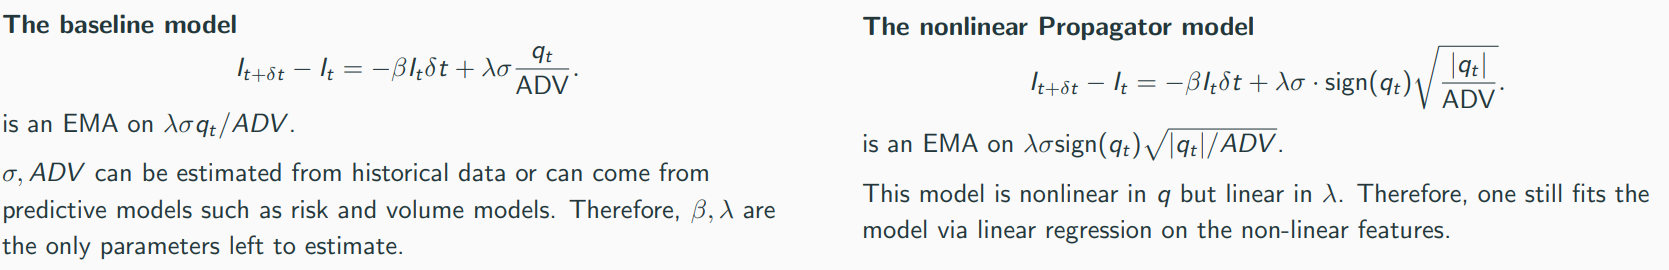

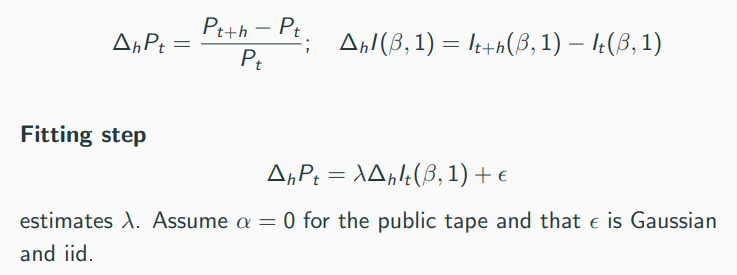

## Estimating the Impact coef $\lambda$ using $R^2$ distribution 

Grid search of the optimal parameters for the price impact models (Half-life and $\lambda$)

In [20]:
half_lifes = [60,600,1200,DEFAULT_HALF_LIFE]
explanation_periods = [2,6,DEFAULT_EXPLANATION_PERIOD,120,360] 
in_sample_month = DEFAULT_IN_SAMPLE_MONTH

index_regression_compute = 1
for half_life in half_lifes:
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="linear") #optionnal
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="sqrt") #optionnal
    for explanation_period in explanation_periods:
        price_impact_model.regression_by_model(half_life=half_life,model_type="linear",explanation_period=explanation_period,in_sample_month=in_sample_month)
        price_impact_model.regression_by_model(half_life=half_life,model_type="sqrt",explanation_period=explanation_period,in_sample_month=in_sample_month)
        print(f"Computing {index_regression_compute} out of {len(half_lifes)*len(explanation_periods)} regressions ...",end="\r")
        index_regression_compute+=1

In [21]:
price_impact_model.get_regression_result_by_key(("sqrt",DEFAULT_HALF_LIFE,DEFAULT_EXPLANATION_PERIOD,DEFAULT_IN_SAMPLE_MONTH)).head(5)

,is_xy,is_xx,is_yy,is_x,is_y,is_count,oos_xy,oos_xx,oos_yy,oos_x,oos_y,oos_count,beta_estimate,alpha_estimate,is_sse,is_mse,is_rsq,oos_sse,oos_mse,oos_rsq
stock,,,,,,,,,,,,,,,,,,,,
A,0.000725,0.000055,0.100247,0.015876,3.100825,48531,0.000499,0.000026,0.048552,-0.010834,1.339147,43909,13.111388,0.000060,0.100049,0.090568,0.094764,0.048512,0.039836,0.178845
AAL,0.005385,0.000249,0.428748,-0.036222,3.718599,48531,0.001500,0.000081,0.126267,-0.231791,-0.880838,43909,21.610756,0.000093,0.428463,0.311962,0.271905,0.126250,0.098840,0.217110
AAP,0.002200,0.000101,0.198188,0.016953,0.209742,48531,0.002326,0.000096,0.197386,-0.002316,-1.437566,43909,21.748651,-0.000003,0.198187,0.150345,0.241400,0.197339,0.141435,0.283291
AAPL,0.002156,0.000119,0.121010,-0.045830,2.418747,48531,0.000895,0.000038,0.048544,-0.075315,0.017307,43909,18.190062,0.000067,0.120890,0.081584,0.325136,0.048544,0.028747,0.407820
ABBV,0.001304,0.000113,0.149813,-0.079270,-1.436474,48531,0.000583,0.000037,0.069370,-0.022565,0.228816,43909,11.592923,-0.000011,0.149770,0.134703,0.100602,0.069369,0.060787,0.123714


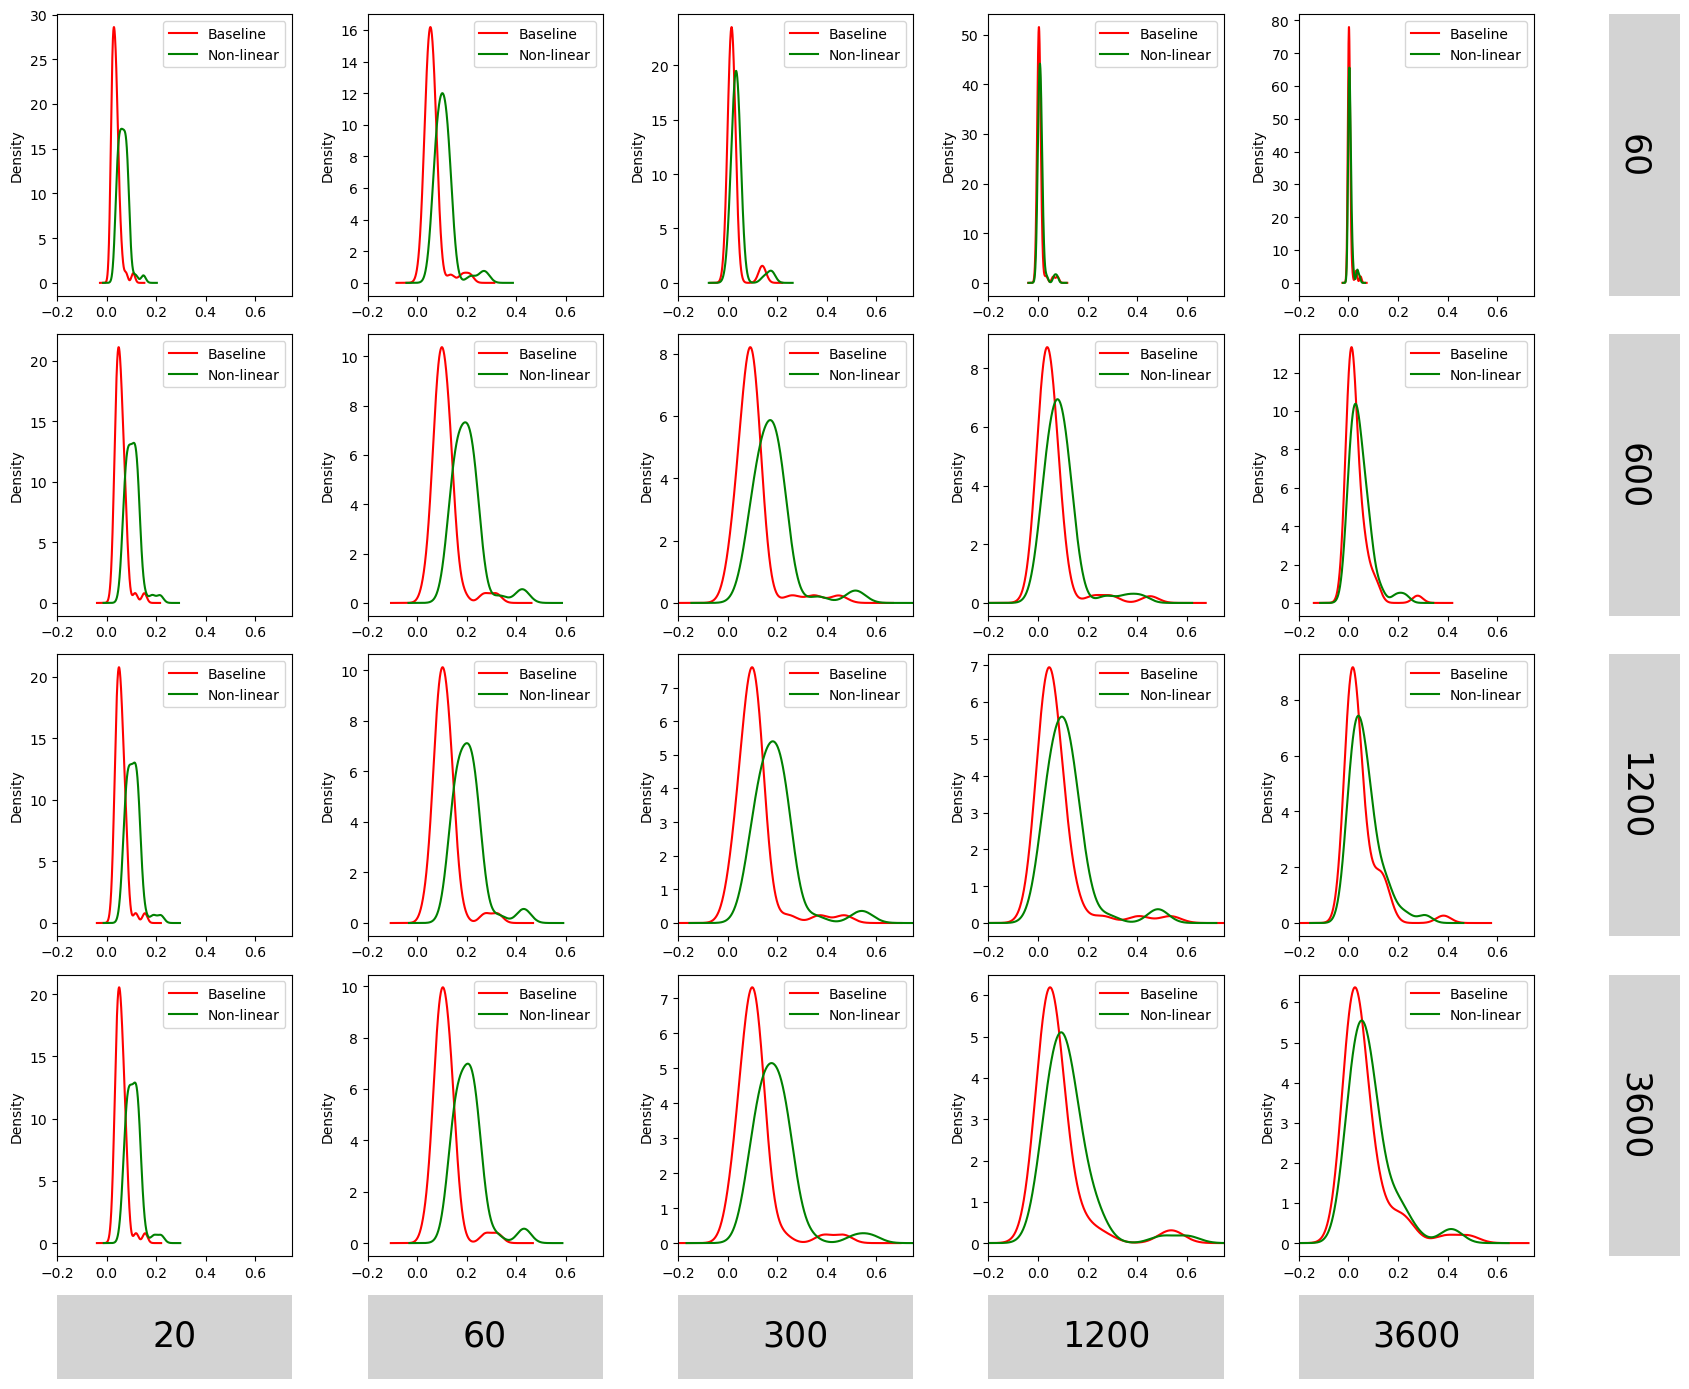

In [22]:
height_ratios = [1.] * len(half_lifes) +  [0.3]
width_ratios = [1.] * len(explanation_periods) + [0.3]

fig,axs = plt.subplots(len(half_lifes)+1,len(explanation_periods)+1,figsize=(len(explanation_periods)*3 + 2,len(half_lifes)*3 + 2),gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
color_model = {"linear":"red","sqrt":"green"}
for hf_index,half_life in enumerate(half_lifes):
    for ep_index,explanation_period in enumerate(explanation_periods):
        ax = axs[hf_index][ep_index]
        price_impact_model.get_regression_result_by_key(("linear",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("linear"),label="Baseline")
        price_impact_model.get_regression_result_by_key(("sqrt",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("sqrt"),label = "Non-linear")
        # ax.set_title(f"{half_life} / {explanation_period}")
        ax.legend()
        ax.set_xlim(-0.2, 0.75)

for hf_index,half_life in enumerate(half_lifes):
    ax = axs[hf_index][-1]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, 1)
    ax.text( 0.1, 0.5, half_life,fontsize = 25, va='center', transform=ax.transAxes,rotation=270)
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
for ep_index,explanation_period in enumerate(explanation_periods):
    ax = axs[-1][ep_index]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0.5, 0.4, explanation_period*10, fontsize = 25,ha='center')
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
ax = axs[-1][-1]
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
# fig.suptitle(t="$R^2$ Distribution amongst stocks for different \nhalf-life (rows) and explanation periods (colomns) ",fontsize = 35)
plt.tight_layout()
plt.show()

## Statistical significance of the impact coef $\lambda$

Compute the statistic $S_{\lambda_{\text{stock}}}=\frac{\bar{\lambda_{\text{stock}}}}{\sigma_{\lambda_{\text{stock}}}}$ to assess the rigidity of the model parameters
We're looking to obtain $S_{\lambda_{\text{stock}}}\geq2$ for all the stocks (95% confidence interval)

In [23]:
max_month = price_impact_model.get_bin_traded_px().index.get_level_values(level = 1).max().month
df_regression_coefficient_stat_significance = pd.DataFrame(index = price_impact_model.get_bin_traded_px().index.get_level_values(level = 0).unique())
for is_month in range(1,max_month):
    for oos_month in range(is_month+1,max_month):
        reg_result = price_impact_model.regression_by_model(half_life=DEFAULT_HALF_LIFE,model_type="sqrt",explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=is_month,out_of_sample_month = oos_month)
        col_name = f"is_{is_month}__os_{oos_month}"
        df_regression_coefficient_stat_significance[col_name] = reg_result["beta_estimate"].copy()

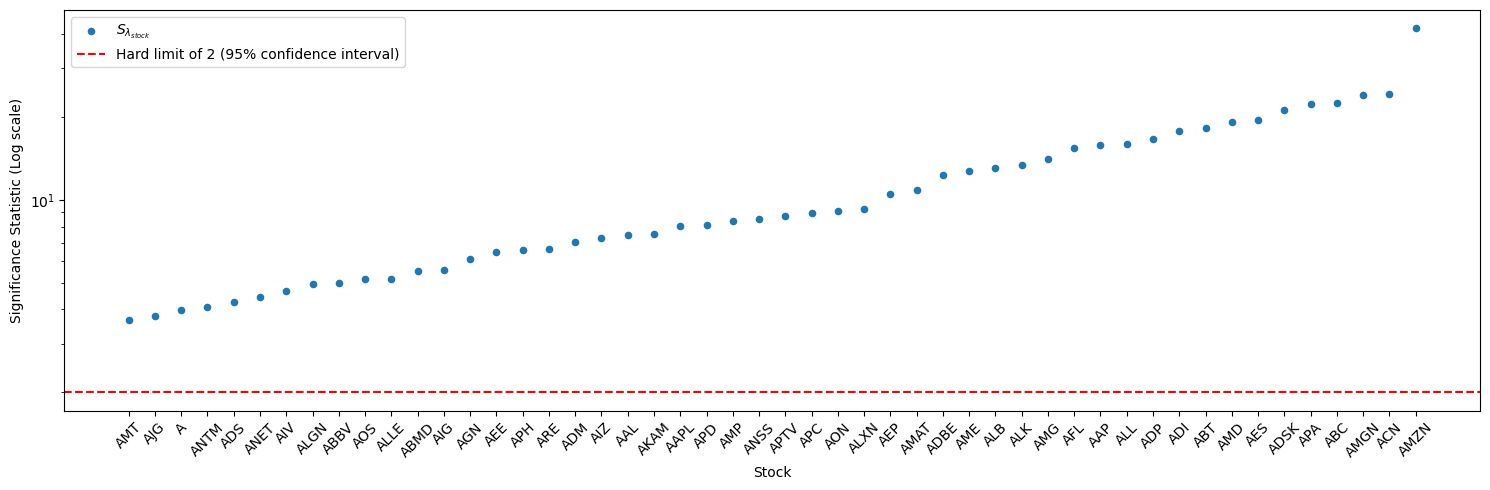

In [24]:
fig,ax = plt.subplots(1,1,figsize = (15,5))
ax.grid(False)
s_stat_df = (df_regression_coefficient_stat_significance.mean(axis=1) / df_regression_coefficient_stat_significance.std(axis=1)).reset_index()
s_stat_df = s_stat_df.rename(columns={0:'Significance Statistic (Log scale)','stock':'Stock'})
s_stat_df = s_stat_df.sort_values(by="Significance Statistic (Log scale)")
s_stat_df.plot.scatter(x="Stock",y="Significance Statistic (Log scale)",ax=ax,grid=False,label="$S_{\lambda_{stock}}$").axhline(y=2,color="red",linestyle="dashed",linewidth = 1.5,label='Hard limit of 2 (95% confidence interval)')
plt.xticks(rotation=45)
plt.yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

# Remove the price impact & Backtesting strategies

## Impact-less price

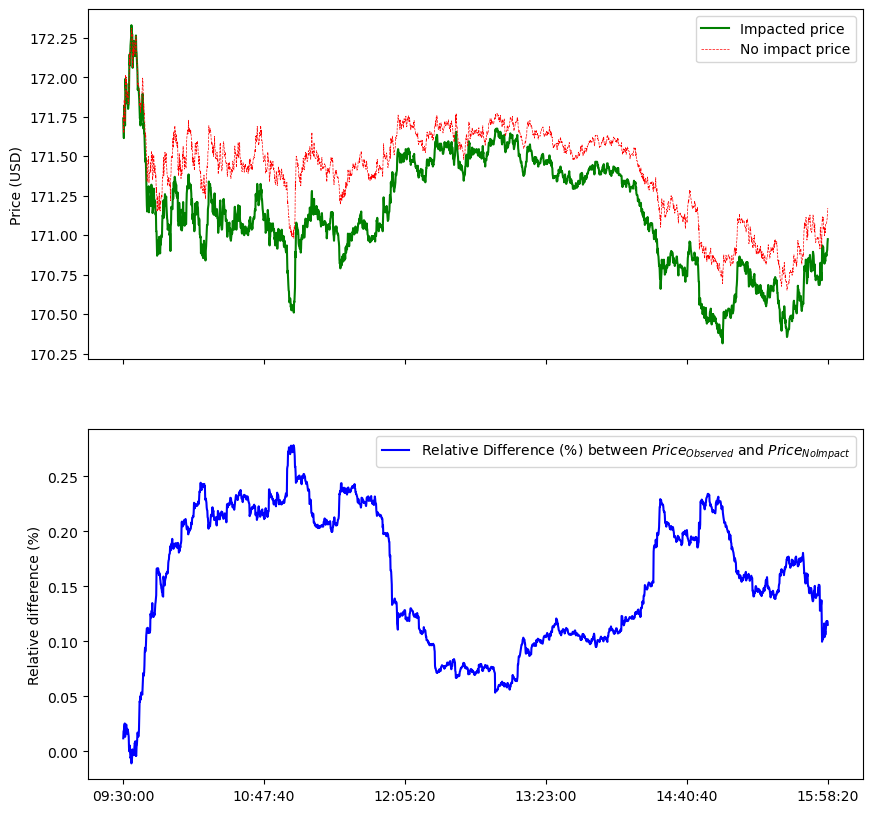

In [25]:
date = "2019-02-21"
stock = "AAPL"
price_no_impact = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type = "linear")

price_no_impact_values = price_no_impact.loc[stock].loc[date]
historical_price = price_impact_model.get_bin_traded_px().loc[stock].loc[date]

fig,axs = plt.subplots(2,1,figsize = (10,10),sharex=True)
x_values = price_no_impact.columns
ax = axs[0]
ax.plot(x_values[:-10],historical_price[:-10],color = "green",label="Impacted price")
ax.plot(x_values[:-10],price_no_impact_values[:-10],color = "red",label="No impact price",linestyle = "dashed",linewidth = 0.5)
ax.set_ylabel("Price (USD)")
ax.legend()
ax = axs[1]
ax.plot(x_values[:-10],((price_no_impact_values - historical_price) / historical_price)[:-10] * 100,color = "blue",label="Relative Difference (%) between $Price_{Observed}$ and $Price_{No Impact}$")
step = len(ax.get_xticks()) // 5
ax.set_xticks(ax.get_xticks()[::step])
ax.set_ylabel("Relative difference (%)")
ax.legend()
# fig.suptitle(f"\nPrice of {stock} on {date} with and without impact from trades",fontsize = 18)
plt.show()

## Backtesting dummy strategies

To backtest a strategy of trades (at interval of 10 seconds) for a given stock - date pair : <br>
    - Compute the impact-free price from historical data<br>
    - Compute the impact of the trading strategy on the impact-free price<br>
    - Add the impact of the trading strategy to the impact-free price<br>
    - Compare the performance of the observe price against the performance of the trading strategie<br>

Target order notional is : 31238649 USD


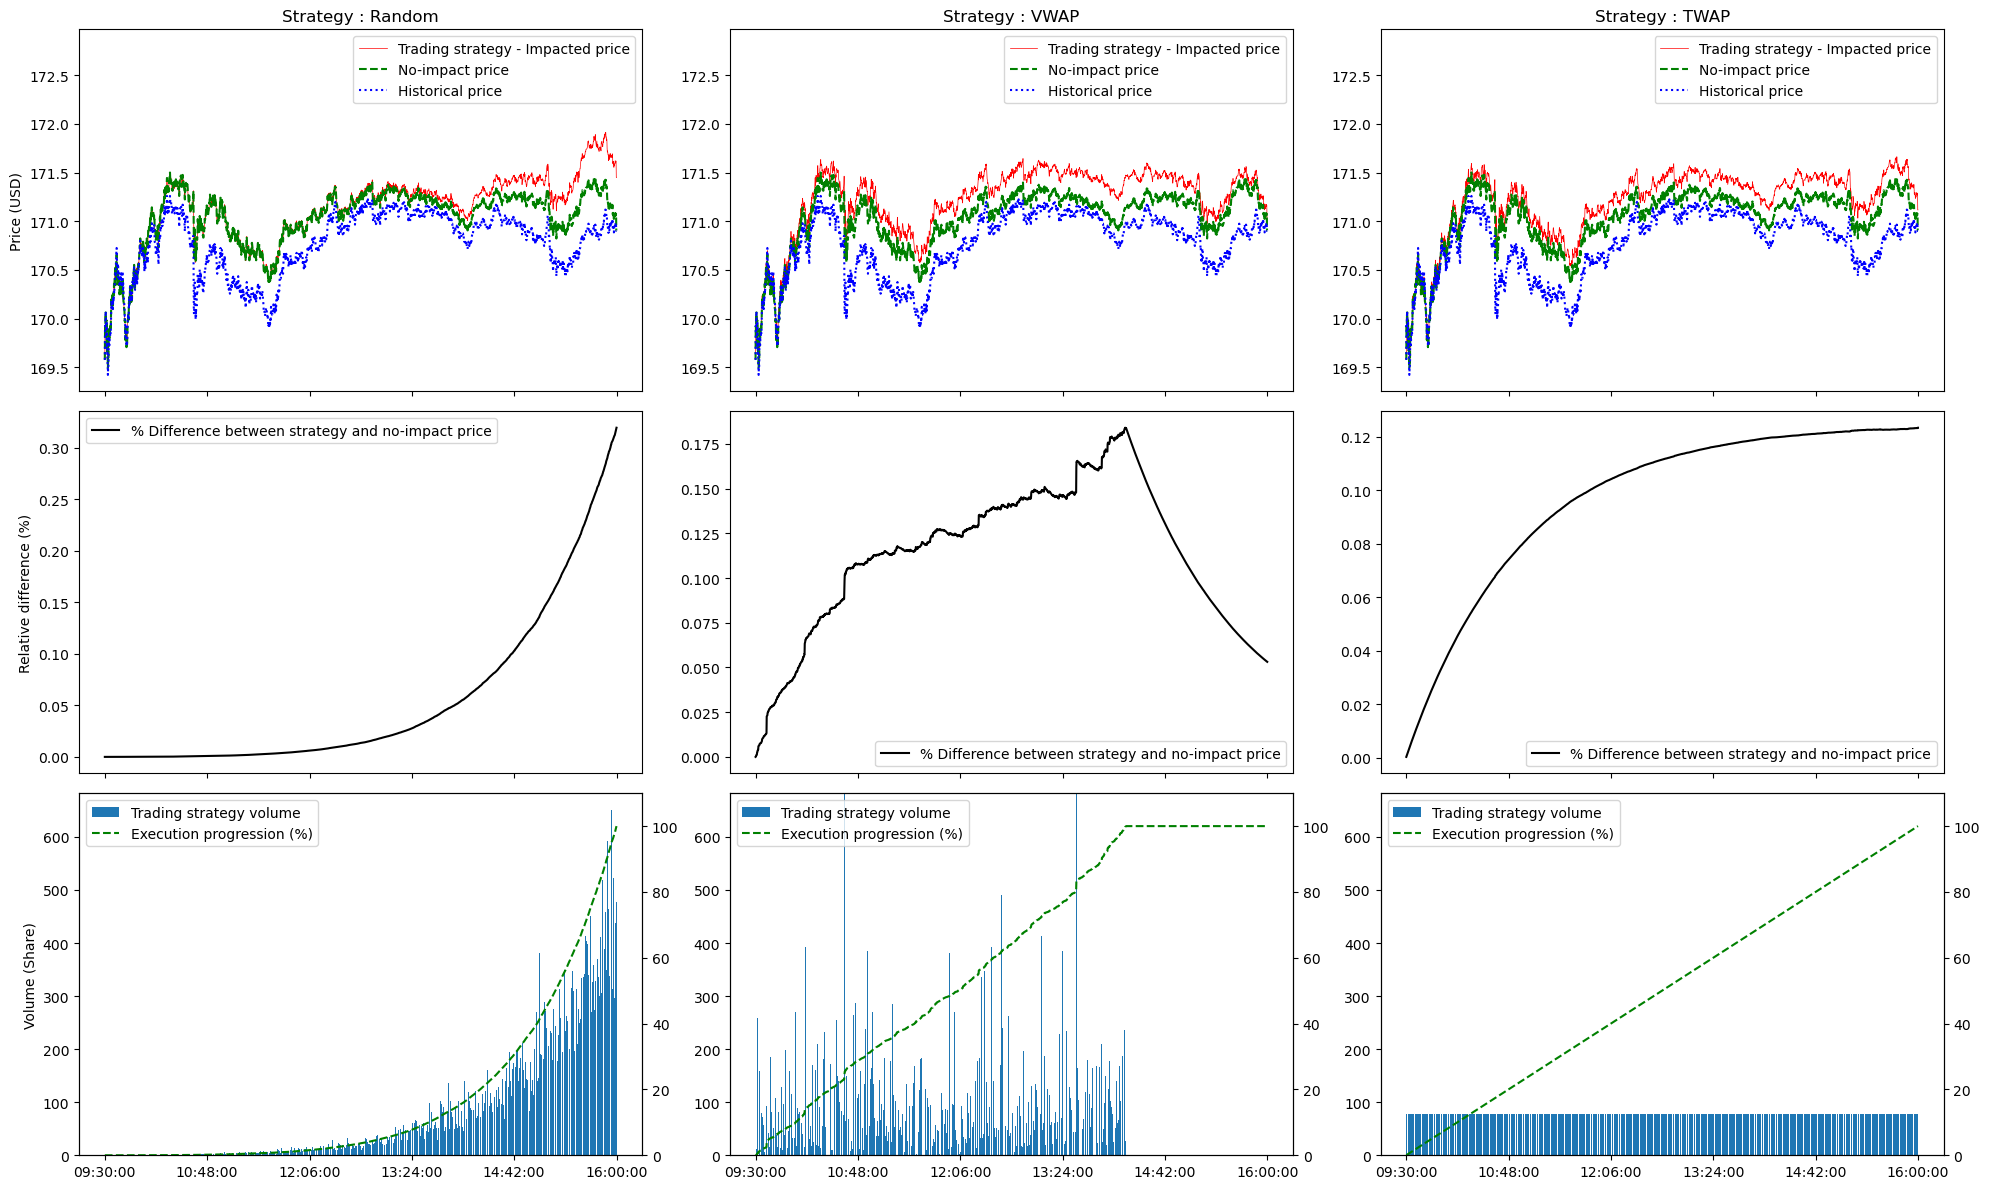

In [26]:
stock = "AAPL"
date = "2019-02-14"
execution_factor = 0.1 # 1% of total volume
model_type = "linear"

# trading_strategy = bin_traded_volume.loc[stock].loc[date].values * 100. # we trade all trades with 10% of the volume
historical_price = price_impact_model.get_bin_traded_px().loc[stock].loc[date]
historical_volume = price_impact_model.get_bin_traded_volume().loc[stock].loc[date]
target_volume = historical_volume.abs().sum() * execution_factor
no_impact_price = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type=model_type).loc[stock].loc[date]

print(f"Target order notional is : {target_volume * historical_price[0]:.0f} USD")

volume_curve = price_impact_model.get_volume_curve_from_data()
random_trading_strategy = np.array(range(len(historical_price)))/len(historical_price) + np.random.normal(loc = 0,scale = 100/len(historical_price),size=historical_price.size)
random_trading_strategy = np.exp(10 * np.sqrt(np.abs(random_trading_strategy)))
random_trading_strategy = random_trading_strategy * target_volume / random_trading_strategy.sum()
vwap_strategy = VWAP_realistic(v = historical_volume.values, Q = target_volume, V = volume_curve.loc[stock].values)
vwap_strategy = vwap_strategy.astype(np.float64)
twap_strategy = TWAP(v = historical_price, Q = target_volume)

random_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = random_trading_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)
vwap_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = vwap_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)
twap_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = twap_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)

strategies = [(random_strategy_price,random_trading_strategy,"Random"),(vwap_strategy_price,vwap_strategy,"VWAP"),(twap_strategy_price,twap_strategy,"TWAP")]

fig,axs = plt.subplots(3,3,figsize = (20,12),sharex=True)
x_values = historical_price.index

for index_strat,(strat_price,strat_volume,strat_name) in enumerate(strategies):
    ax = axs[0][index_strat]
    ax.plot(x_values,strat_price,color = "red",label="Trading strategy - Impacted price",linewidth = 0.5)
    ax.plot(x_values,no_impact_price,color = "green",label="No-impact price",linestyle="dashed")
    ax.plot(x_values,historical_price,color = "blue",label="Historical price", linestyle=":")
    ax.set_title(f"Strategy : {strat_name}")
    ax.legend()
    ax.set_ylim((historical_price.min()*0.999,historical_price.max()*1.01))
    if index_strat==0:
        ax.set_ylabel("Price (USD)")
    step = len(ax.get_xticks()) // 5
    ax.set_xticks(ax.get_xticks()[::step])
    ax = axs[1][index_strat]
    if index_strat==0:
        ax.set_ylabel("Relative difference (%)")
    ax.plot(x_values,(strat_price-no_impact_price)/no_impact_price * 100,label= "% Difference between strategy and no-impact price",color ="black")
    ax.legend()
    ax = axs[2][index_strat]
    ax_percent = ax.twinx()
    if index_strat==0:
        ax.set_ylabel("Volume (Share)")
    ax.bar(x_values,strat_volume,label="Trading strategy volume")
    ax_percent.plot(x_values,np.cumsum(strat_volume)/target_volume * 100,label='Execution progression (%)',linestyle="dashed",color="green")
    ax.set_ylim((0,target_volume / 360/7.5 * 10))
    ax_percent.set_ylim((0,110))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_percent.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")
plt.tight_layout()
plt.show()

# Synthetic Alphas

## Synth alpha generation

### First look at the alpha signals

General synthetic alpha signals for mutliple values of constrained correlation

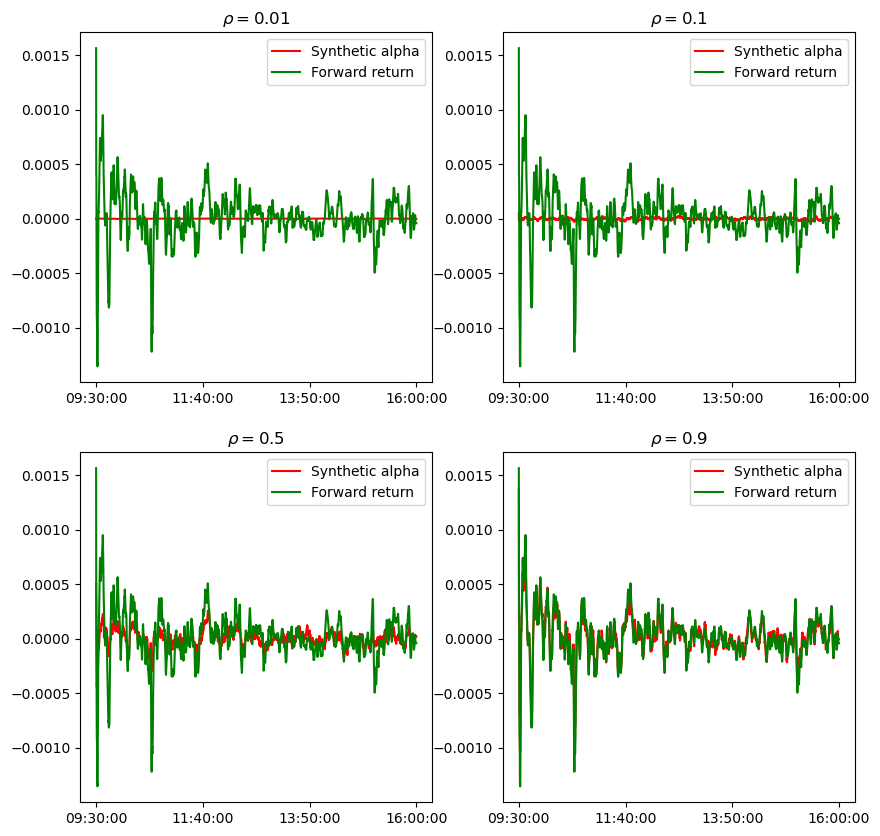

In [27]:
date = "2019-02-14"
stock = "AAPL"

rhos = [.01,.1,.5,.9]
h = 6 * 1 # 1 minutes
w = 6 * 5 # 5 minutes

fig,axs = plt.subplots(2,2,figsize=(10,10))

for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        rho = rhos[row * 2 + col]
        synth_alpha = price_impact_model.synthetic_alpha(h=h,rho = rho).loc[stock].loc[date]
        forward_return = price_impact_model.get_forward_return(prices = price_impact_model.get_bin_traded_px(),h = h).loc[stock].loc[date]
        synth_alpha = pd.Series(synth_alpha).ewm(span = w,adjust=True).mean().dropna()
        forward_return = pd.Series(forward_return).ewm(span = w,adjust=True).mean().dropna()
        ax.set_title(r"$\rho=$"+str(rho))
        ax.plot(synth_alpha,color="red",label = r"Synthetic alpha")
        ax.plot(forward_return,color="green",label=f"Forward return")
        step = len(ax.get_xticks()) // 3
        ax.set_xticks(ax.get_xticks()[::step])
        ax.legend()
plt.show()

### Sample correlation between forward returns and synthetic alphas

Challenge the quality of the synthetic alphas by computing the sample correlation of alphas and forward returns, for a given correlation $\rho$, the sample correlation should be distributed around this value

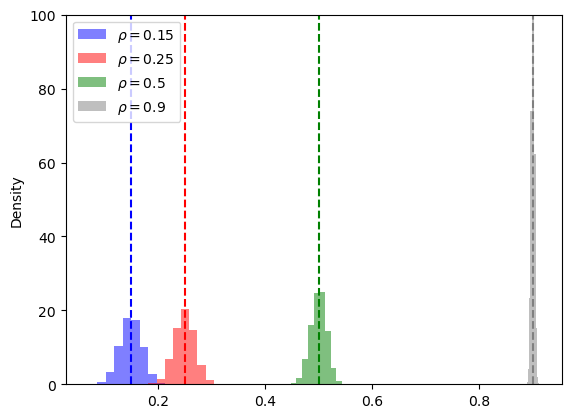

In [28]:
rhos_colors = [(.15,"blue"),(.25,"red"),(.5,"green"),(.9,"gray")]
h = 6 * 1 # 1 minutes

fig,ax = plt.subplots(1,1)
for rho,color in rhos_colors:
    synth_alpha = price_impact_model.synthetic_alpha(h=h,rho = rho)
    forward_return = price_impact_model.get_forward_return(prices = price_impact_model.get_bin_traded_px(),h = h)
    corr = synth_alpha.corrwith(forward_return,axis=1).values
    ax.hist(corr,label=r"$\rho = $" + str(rho),alpha = .5,color=color,density = True)
    ax.vlines(x = rho,ymin = 0,ymax=100,color=color,linestyle="dashed",linewidth=1.5)
ax.set_ylabel("Density")
ax.set_ylim((0,100))
ax.legend()
plt.show()

### Alpha-impacted price

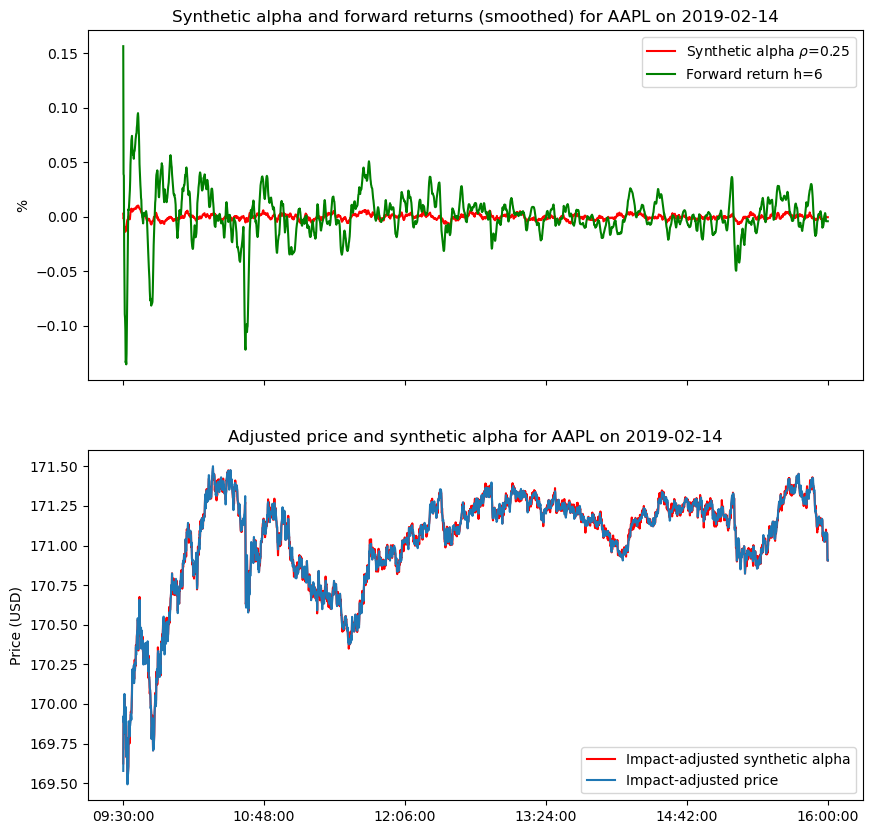

In [29]:
date = "2019-02-14"
stock = "AAPL"

rho = .25
h = 6 * 1 # 5 minutes
w = 6 * 5 # 5 minutes
model_type = "linear"

synth_alpha = price_impact_model.synthetic_alpha(h=h,rho = rho).loc[stock].loc[date]
forward_return = price_impact_model.get_forward_return(prices = price_impact_model.get_bin_traded_px(),h = h).loc[stock].loc[date]

impact_adjusted_prices = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type=model_type).loc[stock].loc[date]
# synth_adjusted_alpha = impact_adjusted_prices* (1+price_impact_model.impact_adjusted_alpha(half_life=DEFAULT_HALF_LIFE,model_type=model_type,h = h,rho = rho).loc[stock].loc[date]).shift(h).fillna(1)
synth_adjusted_alpha = price_impact_model.impact_adjusted_price_with_synth_alpha(half_life=DEFAULT_HALF_LIFE,model_type=model_type,h = h,rho = rho,smoothing_factor=None).loc[stock].loc[date]

fig,axs = plt.subplots(2,1,figsize = (10,10),sharex=True)

ax = axs[0]
synth_alpha = pd.Series(synth_alpha).ewm(span = w,adjust=True).mean().dropna()
forward_return = pd.Series(forward_return).ewm(span = w,adjust=True).mean().dropna()

ax.plot(synth_alpha*100,color="red",label = r"Synthetic alpha $\rho$=" + str(rho))
ax.plot(forward_return*100,color="green",label=f"Forward return h={h}")
ax.set_ylabel("%")
ax.legend()

step = len(ax.get_xticks()) // 5
ax.set_xticks(ax.get_xticks()[::step])

ax.set_title(f"Synthetic alpha and forward returns (smoothed) for {stock} on {date}")

ax = axs[1]

ax.plot(synth_adjusted_alpha,color = "red", label="Impact-adjusted synthetic alpha")
ax.plot(impact_adjusted_prices,label="Impact-adjusted price")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.set_title(f"Adjusted price and synthetic alpha for {stock} on {date}")
plt.show()

## Optimal trading strategy

### Dashboard

In [30]:
alpha_signal,target_impact,optimal_trade,exp_pnl,realised_pnl = price_impact_model.optimal_impact_state(h=15,half_life=10,model_type="sqrt",rho = 0.15,delta_T=15,smoothing_factor= .75,transaction_cost_enable = False)

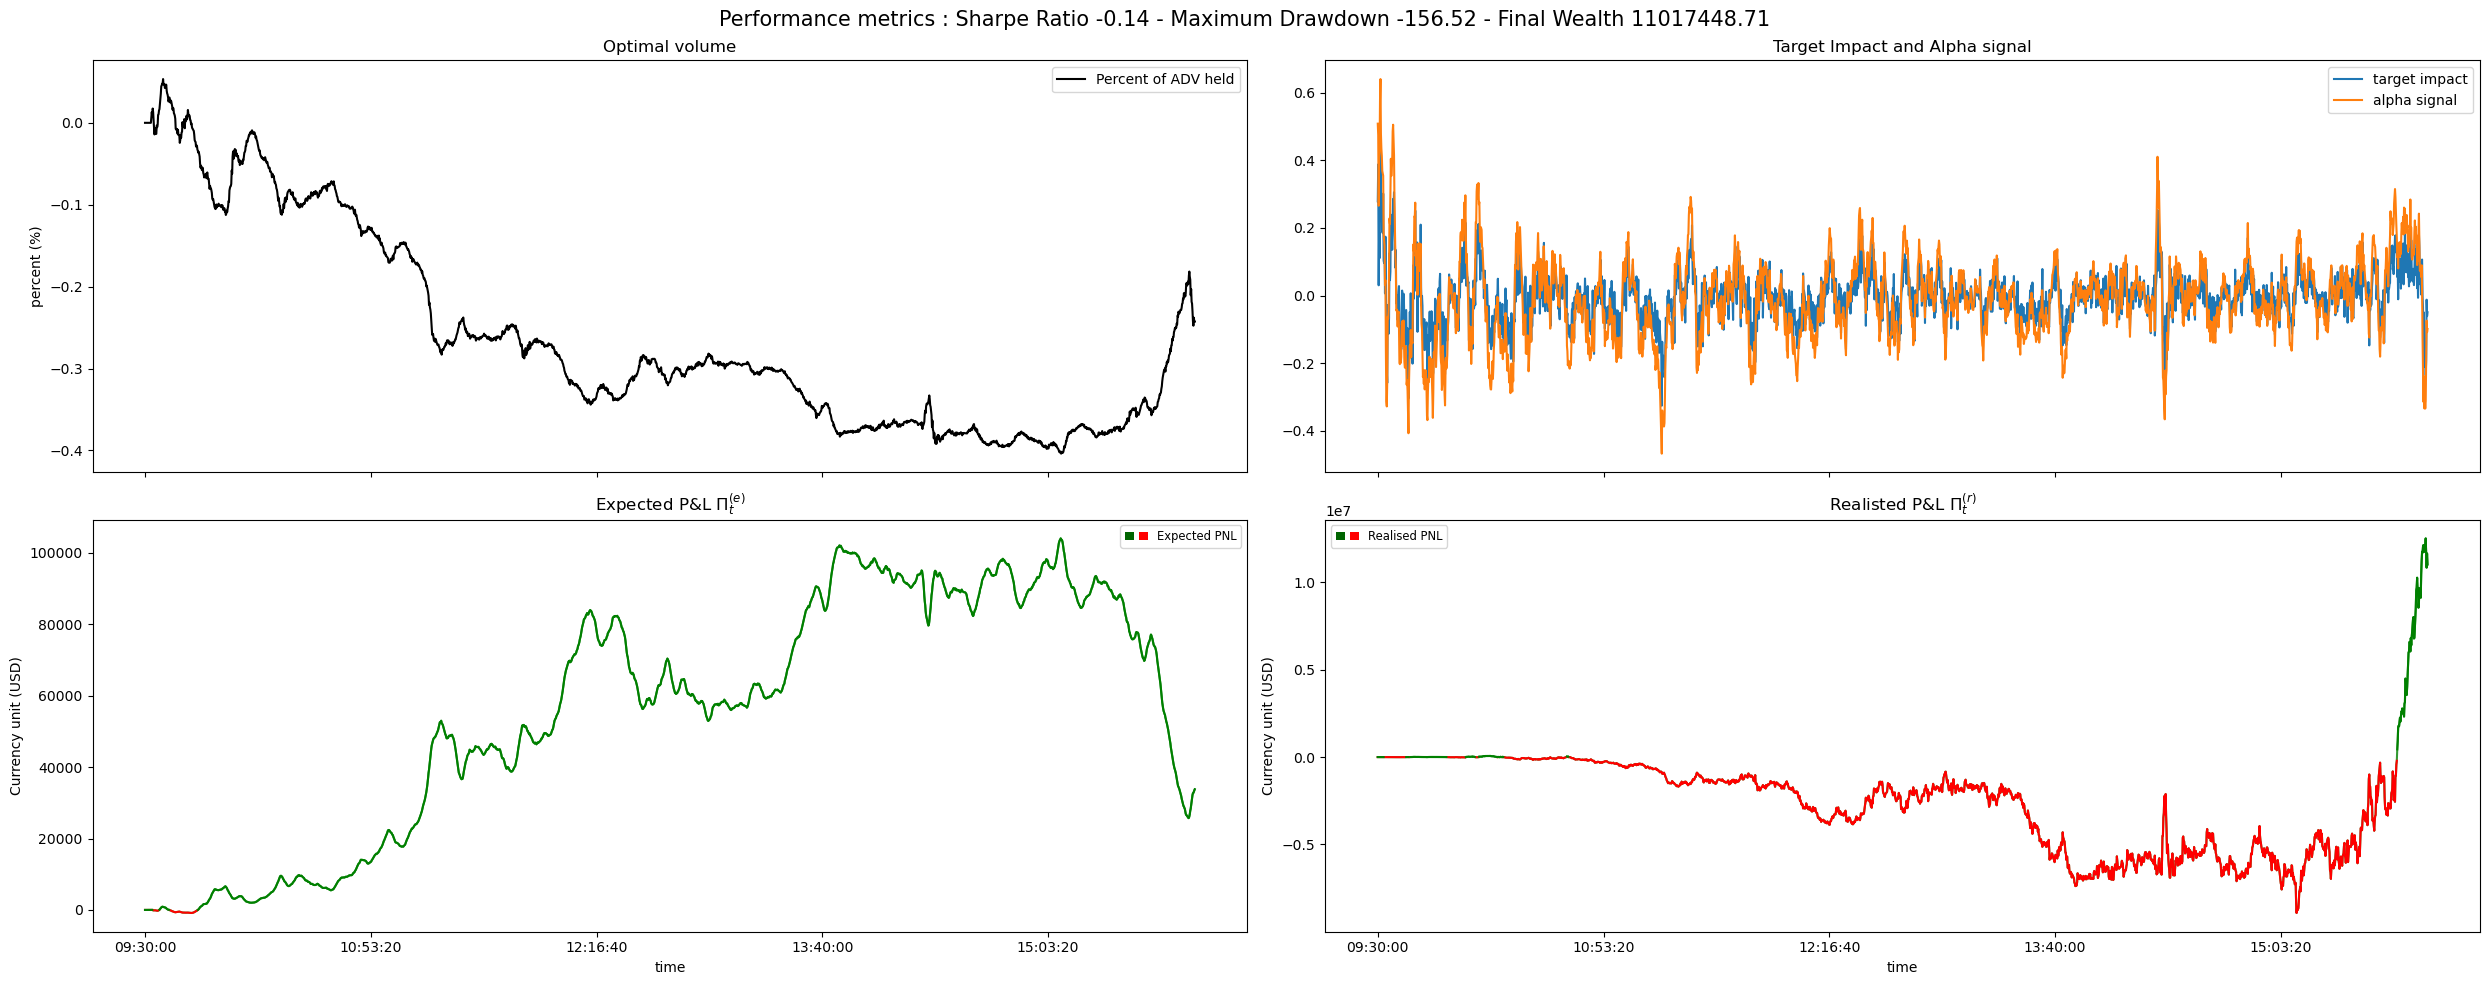

In [31]:
fig,axs = plt.subplots(2,2,figsize=(25,10),sharex=True)

date = "2019-03-15"

(optimal_trade.loc[DEFAULT_STOCK].loc[date].divide(adv_vol.loc[DEFAULT_STOCK].loc[date,"volume"])*100).plot(ax=axs[0][0],label="Percent of ADV held",color="black")
axs[0][0].set_title("Optimal volume")
axs[0][0].legend()
axs[0][0].set_ylabel("percent (%)")

(target_impact.loc[DEFAULT_STOCK].loc[date]).plot(ax=axs[0][1],label="target impact")
(alpha_signal.loc[DEFAULT_STOCK].loc[date]).plot(ax=axs[0][1],label="alpha signal")

axs[0][1].legend()
axs[0][1].set_title("Target Impact and Alpha signal")

patchList = [[mpatches.Patch(facecolor=c) for c in ['#006400','#FF0000']]]


exp_pnl_stock_date_pair = exp_pnl.loc[DEFAULT_STOCK].loc[date]
exp_pnl_stock_date_pair.plot(ax=axs[1][0],color="green",alpha = .8)
exp_pnl_stock_date_pair.mask(exp_pnl_stock_date_pair>0).plot(ax=axs[1][0],color="red")
exp_pnl_stock_date_pair.mask(exp_pnl_stock_date_pair<0).plot(ax=axs[1][0],color="green")
axs[1][0].set_title("Expected P&L $\Pi_t^{(e)}$")
axs[1][0].set_ylabel("Currency unit (USD)")
axs[1][0].legend(handles=patchList, labels=["Expected PNL"], ncol=2, fontsize='small',
           handler_map = {list: HandlerTuple(None)})

realised_pnl_stock_date_pair = realised_pnl.loc[DEFAULT_STOCK].loc[date]
realised_pnl_stock_date_pair.plot(ax=axs[1][1],color="green",alpha = .8)
realised_pnl_stock_date_pair.mask(realised_pnl_stock_date_pair>0).plot(ax=axs[1][1],color="red")
realised_pnl_stock_date_pair.mask(realised_pnl_stock_date_pair<0).plot(ax=axs[1][1],color="green")

axs[1][1].legend(handles=patchList, labels=["Realised PNL"], ncol=2, fontsize='small',
           handler_map = {list: HandlerTuple(None)})
axs[1][1].set_title("Realisted P&L $\Pi_t^{(r)}$")
axs[1][1].set_ylabel("Currency unit (USD)")
fig_title = "Performance metrics : " + " - ".join([f"{k} {round(v,2)}" for k,v in calculate_performance_metrics(realised_pnl.loc[DEFAULT_STOCK].loc[date]).items()])
fig.suptitle(fig_title,fontsize = 15)
plt.tight_layout()
plt.show()



### Table of perfomance with increasing correlation $\rho$

In [32]:
rhos = [.01,.1,.25,.5,.75,.99]
# rhos = [.01]
result_dataframe = pd.DataFrame(index=rhos,columns= ['Sharpe Ratio','Maximum Drawdown','Final Wealth'])
for rho in rhos:
    _,_,_,_,realised_pnl = price_impact_model.optimal_impact_state(h=15,half_life=10,model_type="sqrt",rho = rho,delta_T=15,smoothing_factor= .15)
    perf = calculate_performance_metrics(realised_pnl.loc[DEFAULT_STOCK].loc[DEFAUL_DATE])
    result_dataframe.loc[rho] = pd.Series(perf)
result_dataframe.index.name = "rho"
display(result_dataframe)

,Sharpe Ratio,Maximum Drawdown,Final Wealth
rho,,,
0.01,0.299688,-202.158756,-283270.054945
0.10,0.092092,-140.243375,-295402.583719
0.25,-0.454982,-1222.567222,-290286.015787
0.50,0.19933,-129.606756,-270539.344312
0.75,0.492108,-41.409222,-265969.983102
0.99,0.44048,-178.62014,-314046.228693


### Transaction cost impact on P&Ls

In [33]:
adjusted_prices = price_impact_model.get_no_impact_prices_df(half_life=10,model_type="sqrt")
alpha_signal,target_impact,optimal_trade,exp_pnl_no_cost,realised_pnl_no_cost = price_impact_model.optimal_impact_state(h=15,half_life=10,model_type="sqrt",rho = 0.15,delta_T=15,smoothing_factor= .75,transaction_cost_enable = False)

In [34]:
transaction_cost_df = price_impact_model.get_bin_traded_spread()
# transaction_cost_df = adjusted_prices.copy() * 0.001
#### We re-compute the transaction cost impact PNL outside of the class to get the same alpha signals (random from a brownian motion)
expected_PNL_cost = (alpha_signal - target_impact).multiply(optimal_trade,axis="rows").cumsum(axis="columns")\
                    - transaction_cost_df.multiply(optimal_trade).abs().cumsum(axis="columns")
realised_PNL_cost =  adjusted_prices.multiply(optimal_trade.cumsum(axis="columns"))\
                    -(adjusted_prices +target_impact).multiply(optimal_trade).cumsum(axis="columns")\
                    - (transaction_cost_df).multiply(optimal_trade).abs().cumsum(axis="columns")

normal market condition

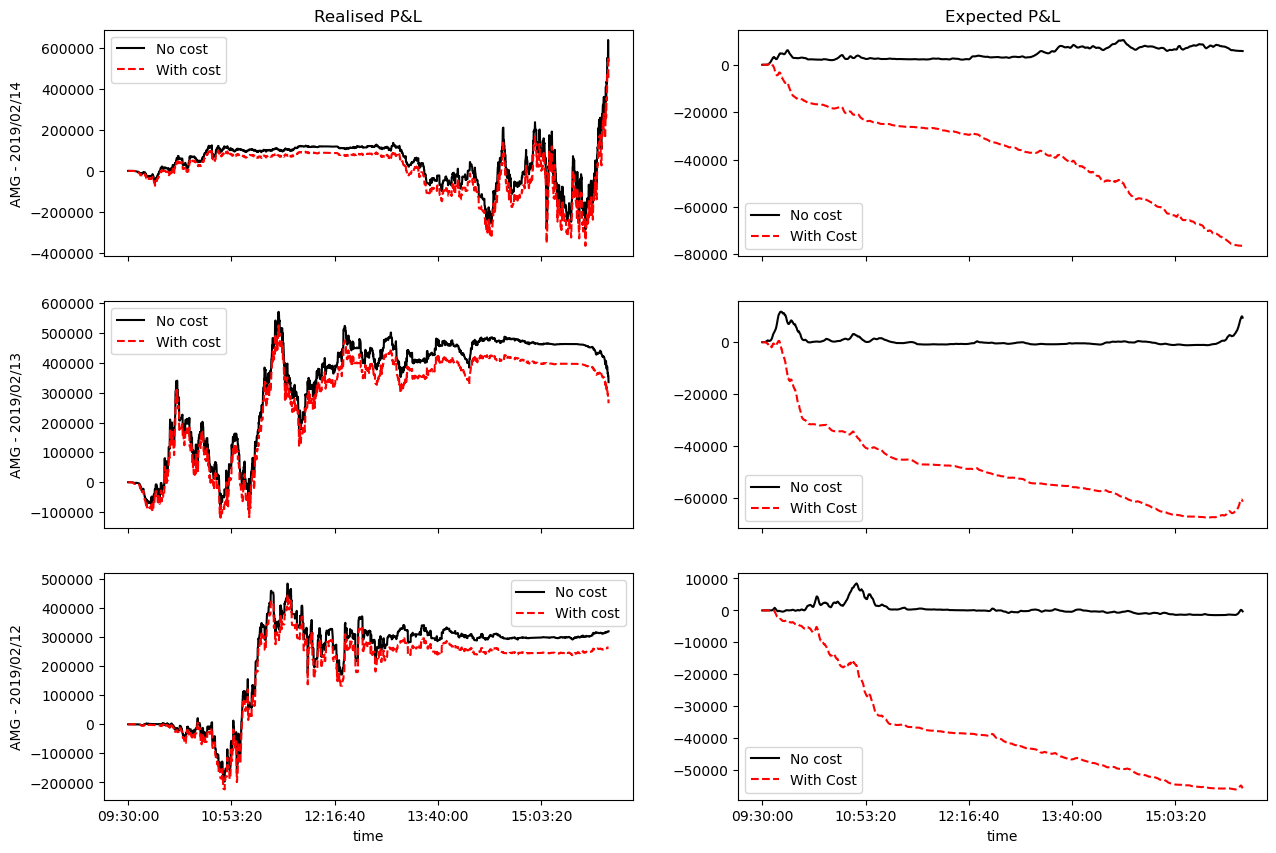

In [35]:
fig,axs = plt.subplots(3,2,figsize = (15,10),sharex=True)

dates = ["2019-02-14","2019-02-13","2019-02-12"]
stock = "AMG"

for index,date in enumerate(dates):
    ax_realised = axs[index][0]
    ax_expected = axs[index][1]

    if index==0:
        ax_realised.set_title("Realised P&L")
        ax_expected.set_title("Expected P&L")

    exp_pnl_no_cost.loc[stock].loc[date].plot(ax=ax_expected,label="No cost",color="black")
    expected_PNL_cost.loc[stock].loc[date].plot(ax=ax_expected,label="With Cost",color="red",linestyle="dashed")
    
    realised_pnl_no_cost.loc[stock].loc[date].plot(ax=ax_realised,label="No cost",color="black")
    realised_PNL_cost.loc[stock].loc[date].plot(ax=ax_realised,label="With cost",color="red",linestyle="dashed")

    ax_realised.set_ylabel(f"{stock} - {date.replace('-','/')}")
    ax_expected.legend()
    ax_realised.legend()

plt.show()

#### Stress test

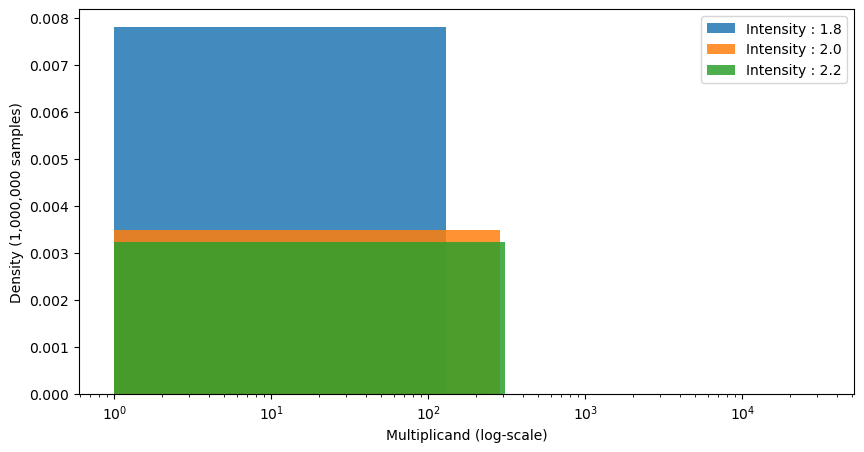

In [36]:
fig,ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(lognorm.rvs(s=1.8,size = 1000000).astype(int) +1,bins=100,label='Intensity : 1.8',alpha = .85,density=True)
ax.hist(lognorm.rvs(s=2.0,size = 1000000).astype(int) +1,bins=100,label='Intensity : 2.0',alpha = .85,density=True)
ax.hist(lognorm.rvs(s=2.2,size = 1000000).astype(int) +1,bins=100,label='Intensity : 2.2',alpha = .85,density=True)
plt.xscale("log")
ax.legend()
ax.set_xlabel("Multiplicand (log-scale)")
ax.set_ylabel("Density (1,000,000 samples)")
plt.show()

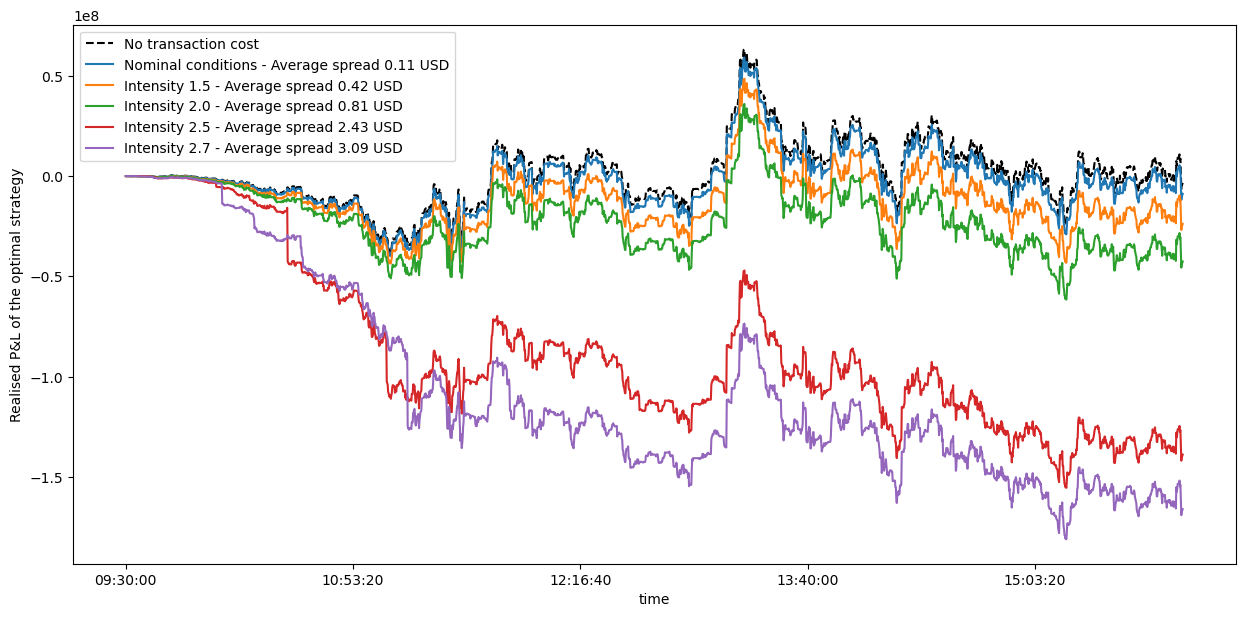

In [37]:
fig,ax = plt.subplots(1,1,figsize = (15,7))

dates = "2019-05-31"
stock = "ALGN"

realised_pnl_no_cost.loc[stock].loc[date].plot(ax=ax,label="No transaction cost",color="black",linestyle="dashed")

new_realised_pnl =  adjusted_prices.multiply(optimal_trade.cumsum(axis="columns"))\
                        -(adjusted_prices +target_impact).multiply(optimal_trade).cumsum(axis="columns")\
                        - (transaction_cost_df).multiply(optimal_trade).abs().cumsum(axis="columns")
average_spread_stock_date_pair = transaction_cost_df.loc[stock].loc[date].mean()

new_realised_pnl.loc[stock].loc[date].plot(ax=ax,label=f"Nominal conditions - Average spread {average_spread_stock_date_pair:.2f} USD")

intensities = [1.5,2.,2.5,2.7]

for hit_intensity in intensities:

    transaction_cost_multiplicator = lognorm.rvs(s=hit_intensity,size = optimal_trade.shape).astype(int) +1

    new_transaction_df = (transaction_cost_df * transaction_cost_multiplicator)

    new_realised_pnl =  adjusted_prices.multiply(optimal_trade.cumsum(axis="columns"))\
                        -(adjusted_prices +target_impact).multiply(optimal_trade).cumsum(axis="columns")\
                        - (new_transaction_df).multiply(optimal_trade).abs().cumsum(axis="columns")
    
    average_spread_stock_date_pair = new_transaction_df.loc[stock].loc[date].mean()
    
    new_realised_pnl.loc[stock].loc[date].plot(ax=ax,label=f"Intensity {hit_intensity} - Average spread {average_spread_stock_date_pair:.2f} USD")

ax.set_ylabel("Realised P&L of the optimal strategy")

ax.legend()
plt.show()

## Side-note on importance of smoothing

Plotting the original un-smoothed alpha signal and the smoothed version using different techniques

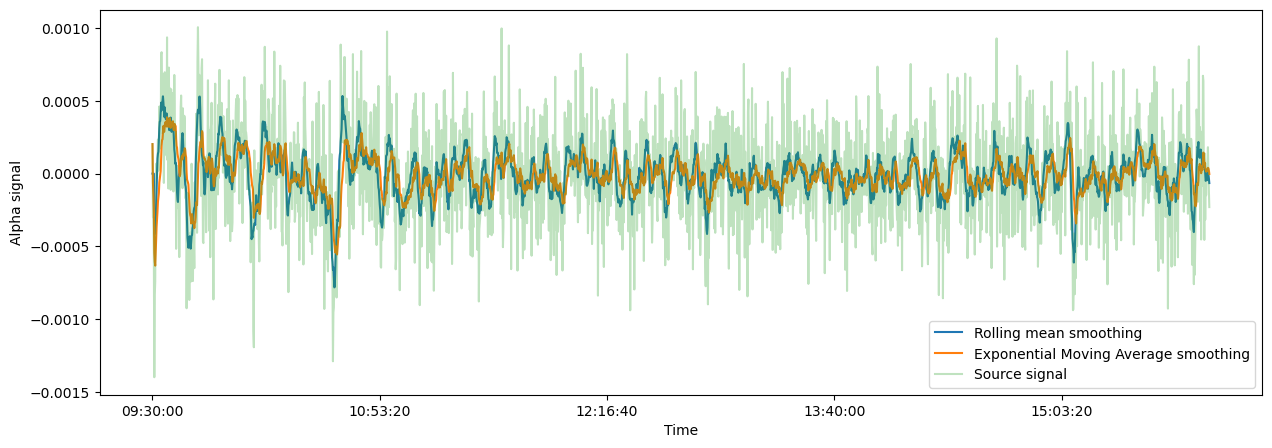

In [38]:
alpha_signal = price_impact_model.synthetic_alpha(h = 10,rho = 0.5)
fig,ax = plt.subplots(1,1,figsize=(15,5))
alpha_signal.loc[DEFAULT_STOCK].loc[DEFAUL_DATE].rolling(10).mean().shift(-5).fillna(0).iloc[:-15].plot(ax=ax,label = "Rolling mean smoothing")
alpha_signal.loc[DEFAULT_STOCK].loc[DEFAUL_DATE].ewm(alpha=.1).mean().fillna(0).iloc[:-15].plot(ax=ax,label="Exponential Moving Average smoothing")
alpha_signal.loc[DEFAULT_STOCK].loc[DEFAUL_DATE].fillna(0).iloc[:-15].plot(ax=ax,alpha=0.3,label="Source signal")
ax.legend()
ax.set_ylabel("Alpha signal")
ax.set_xlabel("Time")
plt.show()
